# exp7. 인물사진 만들기

학습목표
***
딥러닝을 적용하여 핸드폰 인물 사진 모드를 따라 해보자.

목차
***
1. 들어가며
2. 셸로우 포커스 만들기 (1) 사진을 준비하자
3. 셸로우 포커스 만들기 (2) 세그멘테이션으로 사람 분리하기
4. 셸로우 포커스 만들기 (3) 시맨틱 세그멘테이션 다뤄보기
5. 셸로우 포커스 만들기 (4) 배경 흐리게 하기
6. 셸로우 포커스 만들기 (5) 흐린 배경과 원본 영상 합성
7. 프로젝트: 인물 모드 문제점 찾기
8. 프로젝트 제출

## 7.1 셸로우 포커스 만들기 - 사진준비

이미지 세그멘테이션 기술을 이용해 하나의 이미지에서 배경과 사람을 분리
분리된 배경을 blur 처리 후 사람 이미지와 다시 합하면 아웃포커싱 효과를 적용한 인물 사진

1. 배경이 있는 셀카를 촬영
2. Semantic segmentation으로 피사체와 배경을 분리
3. blurring 기술로 배경을 흐리게
4. 피사체를 배경의 원래 위치로 합성

In [22]:
import sys
sys.path.append('C:\\Users\\Helpe\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages') # 라이브러리 경로 오류
import os
import urllib # 웹에서 데이터를 다운로드
import cv2 # OpenCV 라이브러리로 이미지 처리
import numpy as np
from pixellib.semantic import semantic_segmentation # 시맨틱 세그멘테이션 이용
from matplotlib import pyplot as plt
print('슝')

슝


(480, 800, 3)


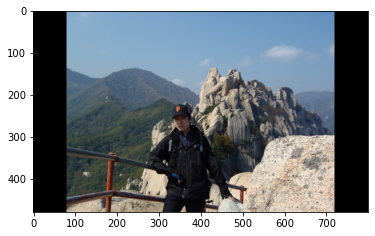

In [23]:
img_path = 'D:/project/aiffel_exp/exp7_human_segmentation/images/image2.jpg'
img_orig = cv2.imread(img_path)

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## 7.2 세그멘테이션으로 사람 분리하기

Segmentation이란?
***
이미지에서 픽셀 다뉘로 관심 객체를 추출하는 방법을 **이미지 세그멘테이션**이라고 함  
이미


semantic segmentation이란?  

세그멘테이션 중에서도 물리적 의미 단위로 인식하는 세그멘테이션을 시멘틱 세그멘테이션 이라고 함.  


## 7.3 시맨틱 세그멘테이션 다뤄보기

In [24]:
# 저장할 파일 이름 결정
model_dir = 'D:/project/aiffel_exp/exp7_human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url
model_url ='https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드
urllib.request.urlretrieve(model_url, model_file)

('D:/project/aiffel_exp/exp7_human_segmentation/models\\deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x1c54bbb9130>)

In [25]:
# 다운로드한 모델을 이용해 `PixelLib`로 세그멘테이션 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [26]:
# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

`segmentAsPascalvoc` 라는 함수 이름에서 세그멘테이션 모델에 대한 힌트를 얻을 수 있는데요.  
PASCAL VOC 데이터로 학습된 모델을 이용한다는 의미입니다.  
모델마다 학습시킨 데이터에 따라 결괏값이 달라지므로 어떤 데이터를 학습시켰는지 확인하는 것은 매우 중요합니다.

In [27]:
# PASCAL VOC 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

20개의 클래스 중 `person` 라벨, 즉 `15`를 가진 영역만 검출해야함

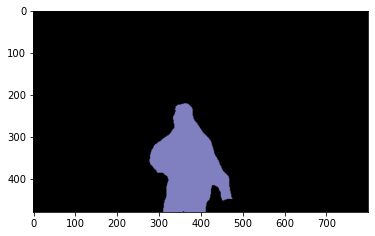

In [28]:
plt.imshow(output)
plt.show()

In [29]:
segvalues

{'class_ids': array([ 0, 15], dtype=int64),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [30]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


`output`에는 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨 있네요.  
`segvalues`에는 `class_ids`와 `masks`가 있습니다.  
`class_ids`를 통해 어떤 물체가 담겨 있는지 알 수 있군요!

이제 물체마다 `output`에 어떤 색상으로 나타나 있는지만 알아내면 될 것 같습니다.

In [31]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [32]:
# 사람을 나타내는 15번째 색상 확인, colormap[class_id]으로 확인 가능함
colormap[15]

array([192, 128, 128])

사람 외에도 다른 물체를 찾아내고 싶다면 `colormap[class_id]`처럼 찾아낼 수 있겠네요!

여기서 주의할 것은 `output` 이미지가 BGR 순서로 채널 배치가 되어 있다는 점이에요. `colormap`은 RGB 순서이고요.

그러니 우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔 줘야 합니다.

In [33]:
seg_color = (128,128,192)

(480, 800)


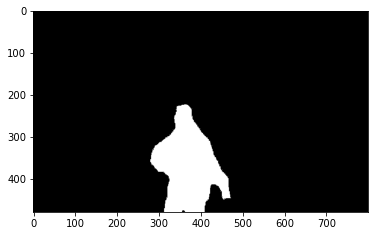

In [34]:
# seg_color 로만 이루어진 마스크 생성
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

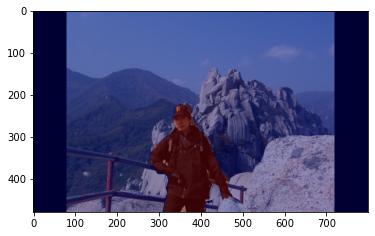

In [35]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 7.4 배경 흐리게 하기

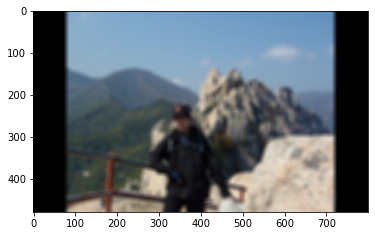

In [36]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

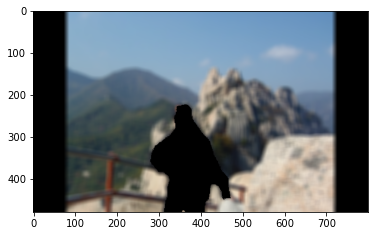

In [37]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

`bitwise_not` 함수를 이용하면 이미지가 반전됩니다.  
원래 마스크에서는 배경이 0, 사람이 255였으니 `bitwise_not` 연산을 하고 나면 배경은 255, 사람은 0이 되겠죠?

반전된 세그멘테이션 결과를 이용해서 이미지와 `bitwise_and` 연산을 수행하면 배경만 있는 영상을 얻을 수 있습니다.  
0과 어떤 수를 `bitwise_and` 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지게 되는 거죠.

## 7.5 흐린 배경과 원본 영상 합성

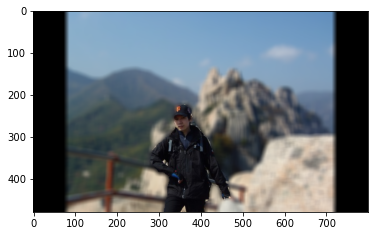

In [38]:
'''
np.where(조건, 참일때, 거짓일때) 코드를 이용해 
세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가져오고
아닌 영역은 블러된 이미지 값을 사용
'''
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 7.6 프로젝트 : 인물 모드 문제점 찾기



In [9]:
import sys
sys.path.append('C:\\Users\\Helpe\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages') # 라이브러리 경로 오류
import os
import urllib # 웹에서 데이터를 다운로드
import cv2 # OpenCV 라이브러리로 이미지 처리
import numpy as np
from pixellib.semantic import semantic_segmentation # 시맨틱 세그멘테이션 이용
from matplotlib import pyplot as plt

from matplotlib import pyplot as plt
import tensorflow as tf

In [3]:
img_path = 'D:/project/aiffel_exp/exp7_human_segmentation/images/image4.jpg'
cow_orig = cv2.imread(img_path) 
print (cow_orig.shape)

(960, 720, 3)


In [11]:
model_dir = 'D:/project/aiffel_exp/exp7_human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# 다운로드한 모델을 이용해 `PixelLib`로 세그멘테이션 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

# 강아지를 나타내는 12번째 색상 확인, colormap[class_id]으로 확인 가능함
colormap[12]

array([ 64,   0, 128])

(960, 720)


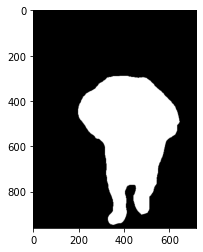

In [26]:
seg_color = (128,0,64)
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

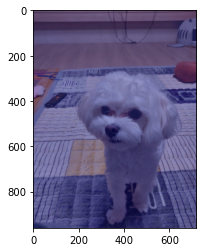

In [27]:
# 사진 중에서 사람의 라벨, 즉 15를 가진 영역만 검출해 봅시다.
img_show = cow_orig.copy()

img_mask = img_mask.astype(np.uint8) * 255

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# 마스크 뽑아내기

cow_mask_up = cv2.resize(cow_mask, cow_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, cow_mask_up = cv2.threshold(cow_mask_up, 128, 255, cv2.THRESH_BINARY)

print(f'cow 마스크 크기: {cow_mask.shape}')

ax = plt.subplot(1,2,2)
plt.imshow(cow_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Cow Size Mask')

plt.show()

In [ ]:
#세그멘테이션 마스크를 이용해서 배경만 추출하겠습니다.
cat_mask_color = cv2.cvtColor(cat_mask_up, cv2.COLOR_GRAY2BGR)
cat_bg_mask = cv2.bitwise_not(cat_mask_color)
cat_bg = cv2.bitwise_and(cat_orig, cat_bg_mask)

cow_mask_color = cv2.cvtColor(cow_mask_up, cv2.COLOR_GRAY2BGR)
cow_bg_mask = cv2.bitwise_not(cow_mask_color)
cow_bg = cv2.bitwise_and(cow_orig, cow_bg_mask)

fig = plt.figure(figsize=(16, 6)) 

ax = plt.subplot(1,2,1)
plt.imshow(cat_bg, cmap=plt.cm.binary_r)
ax.set_title('Cat background')

ax = plt.subplot(1,2,2)
plt.imshow(cow_bg, cmap=plt.cm.binary_r)
ax.set_title('Cow background')

plt.show()

In [ ]:
cow_map = np.where(cow_map == 10, 10, 0) 
cow_mask = cow_map * (255/cow_map.max()) 
cow_mask = cow_mask.astype(np.uint8)

# 원본 사진과 마스크의 크기를 맞춰준다.
cow_mask_up = cv2.resize(cow_mask, cow_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
# 채널을 원본 사진과 맞게 3 channel로 바꾼다.
cow_mask_3C = np.repeat(np.expand_dims(cow_mask_up, axis=2), 3, axis=2).astype(np.uint8)

# 원본 이미지를 가우시안 Blur 처리한다.
cow_orig_blur = cv2.GaussianBlur(cow_orig, (25,25),0)
# 마스크 이미지를 가우시안 Blur 처리한다.
cow_Gmask = (cv2.GaussianBlur(cow_mask_3C, (101, 101), 25, 25)/255).astype(np.float32)

# 마스크와 이미지를 더해준다.
cow_image_blur = cow_Gmask*cow_orig.astype(np.float32)
# 1-마스크를 해주는 이유는 Blur 처리한 원본에서 배경만 뽑아내기 위해서이다.
cow_bg_mask = (1-cow_Gmask)*cow_orig_blur.astype(np.float32)
out = (cow_image_blur+cow_bg_mask).astype(np.uint8)

fig = plt.figure(figsize=(20, 10)) 

ax = plt.subplot(3,1,1)
plt.imshow(cv2.cvtColor(cow_image_blur.astype(np.uint8),cv2.COLOR_BGR2RGB))
ax.set_title('Cat Image blur')

ax = plt.subplot(3,1,2)
plt.imshow(cv2.cvtColor(cow_bg_mask.astype(np.uint8),cv2.COLOR_BGR2RGB))
ax.set_title('Cow background')

ax = plt.subplot(3,1,3)
plt.imshow(cv2.cvtColor(out,cv2.COLOR_BGR2RGB))
ax.set_title('Cow background')

plt.show()